<a href="https://www.kaggle.com/code/jamijubaer/dogs-vs-cats?scriptVersionId=101258003" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install livelossplot

In [2]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers,models
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
from keras.preprocessing.image import load_img
import random

In [3]:
!ls ../input/dogs-vs-cats


sampleSubmission.csv  test1.zip  train.zip


In [4]:
!mkdir datasets

In [5]:
# unzipping test and train files
!unzip -q ../input/dogs-vs-cats/train.zip -d /kaggle/working/datasets/
!unzip -q ../input/dogs-vs-cats/test1.zip -d /kaggle/working/datasets/

In [6]:
!mkdir datasets/train/dog
!mkdir datasets/train/cat


In [7]:
IMAGE_SIZE=128
CHANNELS=3

In [8]:
data_list = os.listdir("./datasets/train")

for word in data_list:
    if word =="cat" or word=="dog":
        continue
    if "cat" in word:
        os.system(f"mv ./datasets/train/{word} ./datasets/train/cat")
    elif "dog" in word:
        os.system(f"mv ./datasets/train/{word} ./datasets/train/dog")



In [9]:
input_path = []
label = []

for class_name in os.listdir("./datasets/train"):
    for path in os.listdir("./datasets/train/"+class_name):
        if class_name == 'cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("./datasets/train/", class_name, path))
print(input_path[0], label[0])

./datasets/train/cat/cat.1065.jpg 0


In [10]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

images  label
0  ./datasets/train/cat/cat.7797.jpg      0
1  ./datasets/train/dog/dog.2802.jpg      1
2  ./datasets/train/dog/dog.1159.jpg      1
3  ./datasets/train/dog/dog.5800.jpg      1
4  ./datasets/train/dog/dog.6958.jpg      1

In [11]:
for i in df['images']:
    if '.jpg' not in i:
        print(i)

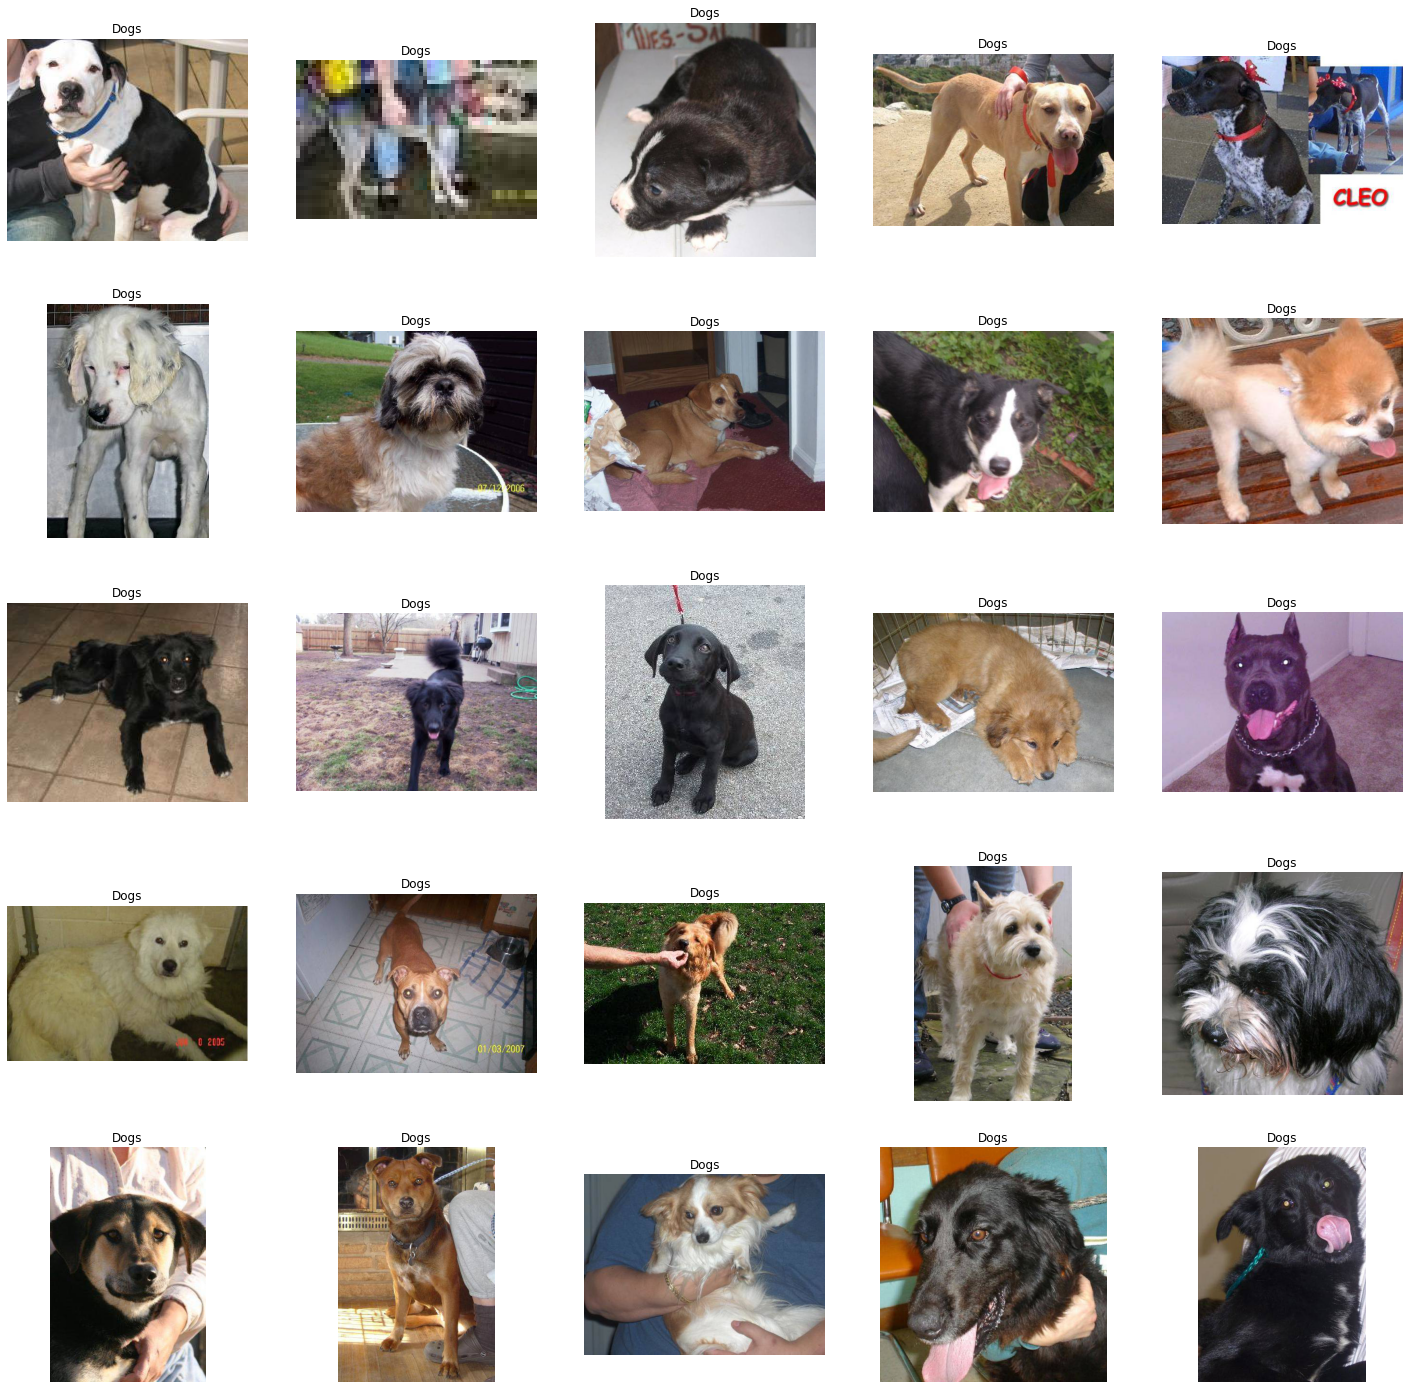

In [12]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

In [13]:
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

2022-07-19 17:46:57.975424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 17:46:58.099594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 17:46:58.100316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 17:46:58.102447: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

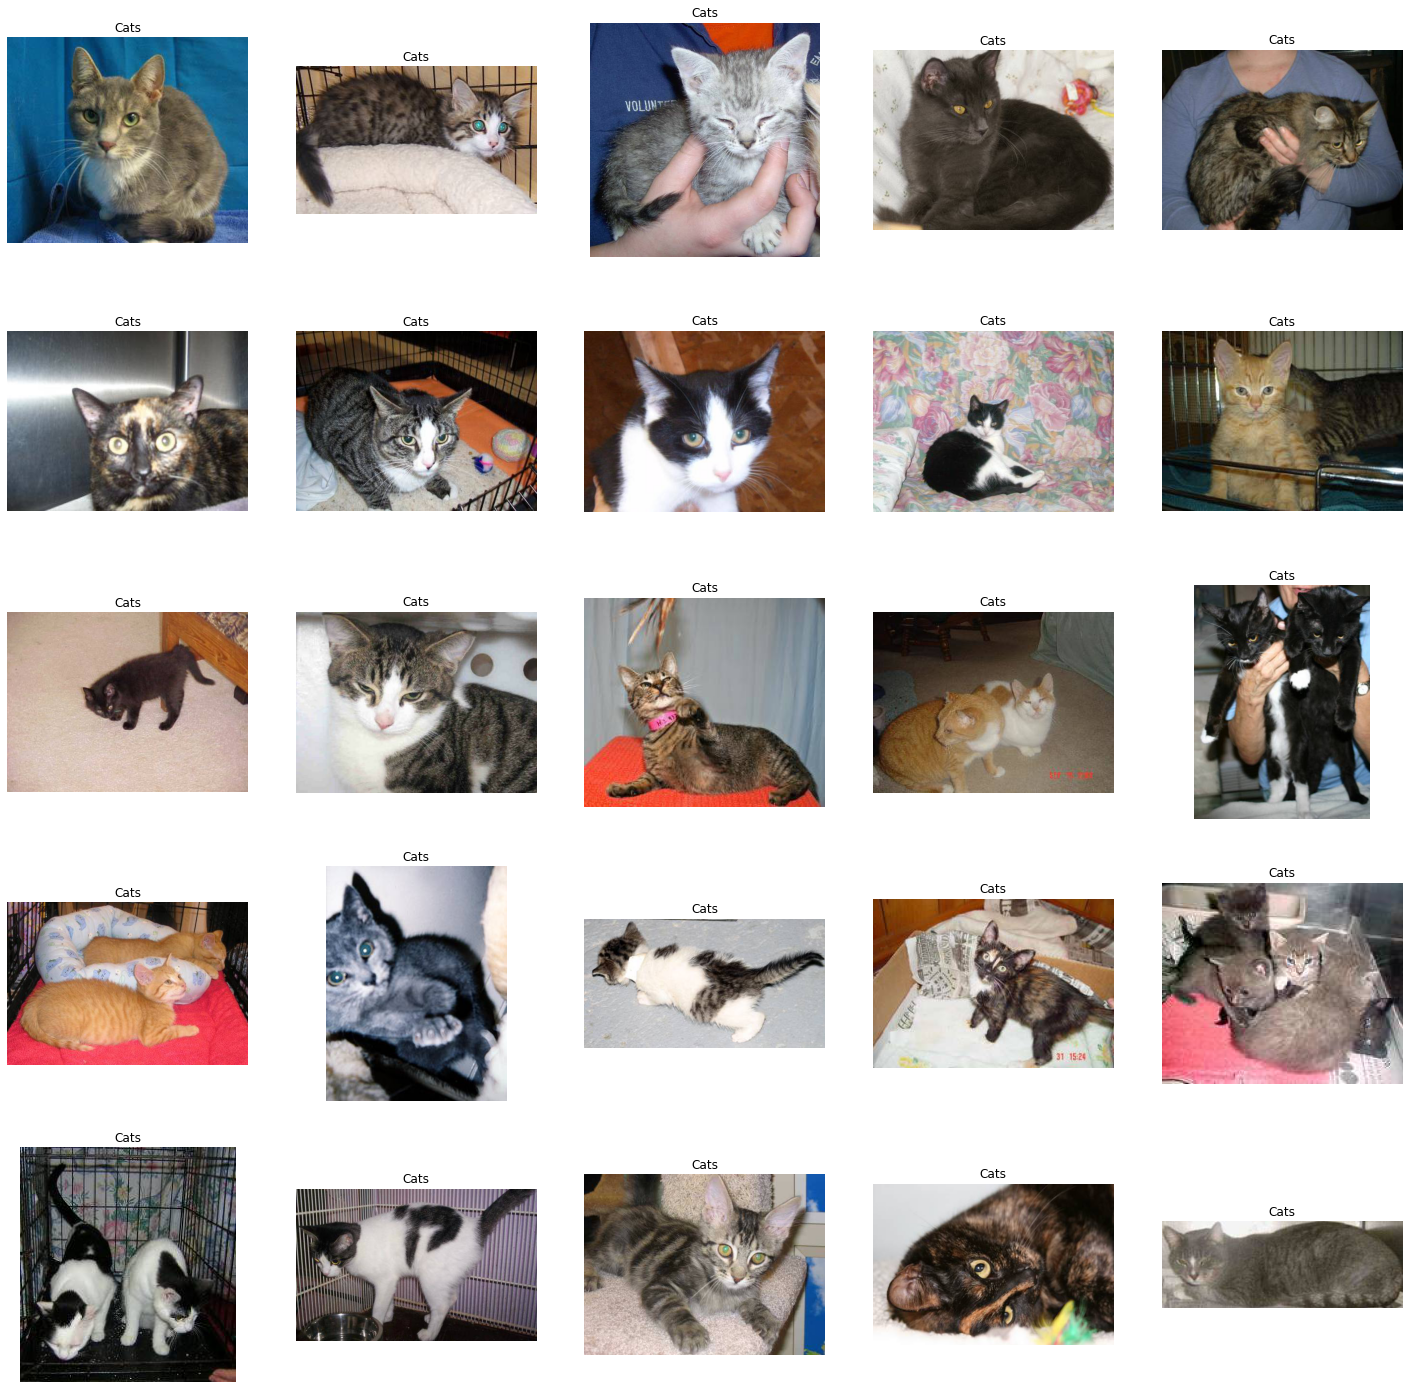

In [14]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

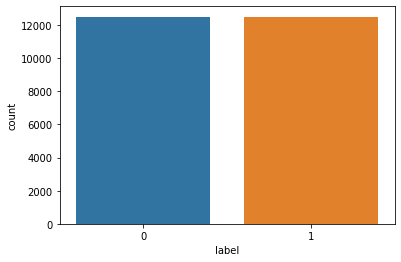

In [15]:
import seaborn as sns
sns.countplot(df['label'])

In [16]:
df['label'] = df['label'].astype('str')

In [17]:
df.head()

images label
0  ./datasets/train/cat/cat.7797.jpg     0
1  ./datasets/train/dog/dog.2802.jpg     1
2  ./datasets/train/dog/dog.1159.jpg     1
3  ./datasets/train/dog/dog.5800.jpg     1
4  ./datasets/train/dog/dog.6958.jpg     1

In [18]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [19]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [20]:
input_shape = ( IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2


model = models.Sequential([
   
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    
    #layers.Conv2D(64, (3, 3), activation='relu'),
   # layers.MaxPooling2D((2, 2)),
    
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    
   # layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               29491712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


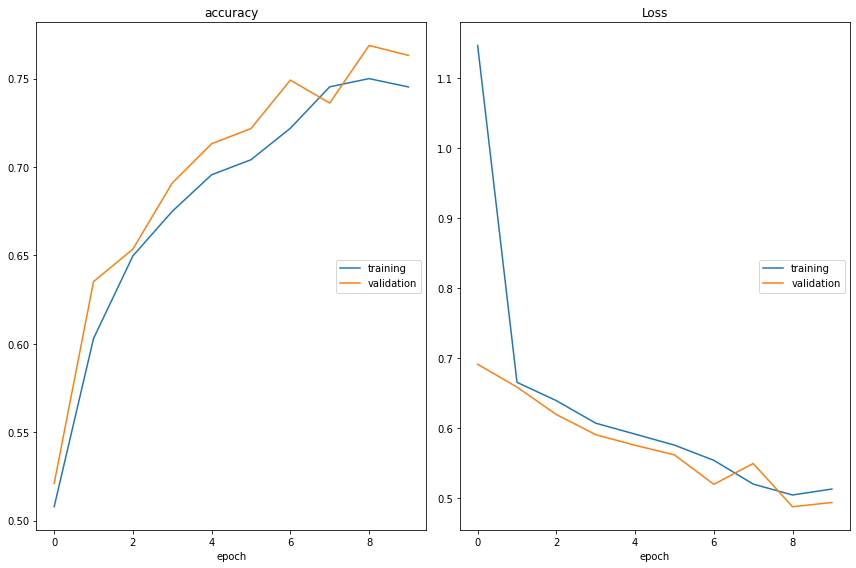

accuracy
	training         	 (min:    0.508, max:    0.750, cur:    0.745)
	validation       	 (min:    0.521, max:    0.769, cur:    0.763)
Loss
	training         	 (min:    0.505, max:    1.147, cur:    0.513)
	validation       	 (min:    0.488, max:    0.691, cur:    0.494)


In [23]:
#model training
history = model.fit(
    train_iterator,
 
    validation_data=val_iterator,
    verbose=1,
    epochs=10,
    callbacks=[PlotLossesKeras()]
    
)

In [24]:
submission_file = pd.read_csv("../input/dogs-vs-cats/sampleSubmission.csv")

In [25]:
submission_file.head()

id  label
0   1      0
1   2      0
2   3      0
3   4      0
4   5      0

In [26]:
input_path = []


for class_name in os.listdir("./datasets/test1"):
    input_path.append(os.path.join("./datasets/test1/", class_name))
print(input_path[0])

./datasets/test1/8835.jpg


In [27]:
test_df = pd.DataFrame()
test_df['images'] = input_path

test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.head()

images
0  ./datasets/test1/1625.jpg
1  ./datasets/test1/9027.jpg
2  ./datasets/test1/4167.jpg
3  ./datasets/test1/2589.jpg
4  ./datasets/test1/5835.jpg

In [28]:
test_df.head()
labels = ["Null" for i in range(len(test_df))]
test_df["label"]=labels

In [29]:
test_df.head()

images label
0  ./datasets/test1/1625.jpg  Null
1  ./datasets/test1/9027.jpg  Null
2  ./datasets/test1/4167.jpg  Null
3  ./datasets/test1/2589.jpg  Null
4  ./datasets/test1/5835.jpg  Null

In [30]:
test_generator = ImageDataGenerator(rescale = 1./255)

test_iterator = test_generator.flow_from_dataframe(
    test_df, 
    x_col='images',
    y_col="label",
    target_size=(128,128), 
    batch_size=512, 
    
)

Found 12500 validated image filenames belonging to 1 classes.


In [31]:
test_labels = model.predict(test_iterator)

In [32]:
test_labels=test_labels.reshape(-1,)

In [33]:
test_labels[0:5]

array([0.283243  , 0.6325869 , 0.42547703, 0.5302642 , 0.06818251],
      dtype=float32)

In [34]:
test_labels_1= [round(i) for i in test_labels]

In [35]:
test_labels_1[0:5]

[0, 1, 0, 1, 0]

In [36]:
test_df["label"]=test_labels_1

In [37]:
test_df.head()

images  label
0  ./datasets/test1/1625.jpg      0
1  ./datasets/test1/9027.jpg      1
2  ./datasets/test1/4167.jpg      0
3  ./datasets/test1/2589.jpg      1
4  ./datasets/test1/5835.jpg      0

In [38]:
id = test_df["images"][0]

In [39]:
test_ids=[]
for i in range(len(test_df)):
    id = test_df["images"][i]
    id = id.split("/")
    id=id[3]
    id = id.split('.')
    id=id[0]
    test_ids.append(id)

In [40]:
test_df["id"]=test_ids
test_df.head()


images  label    id
0  ./datasets/test1/1625.jpg      0  1625
1  ./datasets/test1/9027.jpg      1  9027
2  ./datasets/test1/4167.jpg      0  4167
3  ./datasets/test1/2589.jpg      1  2589
4  ./datasets/test1/5835.jpg      0  5835

In [41]:
test_df=test_df.drop("images",axis=1)

In [42]:
test_df.head()

label    id
0      0  1625
1      1  9027
2      0  4167
3      1  2589
4      0  5835

In [43]:
test_df.to_csv("kaggle_submission.csv",index=False,header=True)